# Brief summary of the project 
Here I examine the use of colibrating filtering algorithms on the movie lens data.

In this project I examine three basic algorithms of collabirating filtering : cosine similartiy, pearson similarty and matrix factorixation vis SVD algorithm using the suprise library. After examination it was found that the matrix factorixation algorithm gives the best result via f1 score and RMSE wise.

Then basing on user similarties, for each user, was created a 10 movie recomandation list and an estimation of the rating.

In addition, I examine another use case - regarding the sutiation that a user is viewing a movie and we want to give him recomandation basing on movies that are similar to this movie. For this , I have used knn - cosine similarty algorithm, and for the user "i", for the movie "j", the top 5 nearest neighbhors to the movie "j", were taken from the recomandation list.

the main object of the project is to get farmilier with the models for colabirating filtering, therefore there is less concentration of the data exploration.

### Summary of the data 
MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# read the data 
movie_rating=pd.read_csv('ratings.csv')
movie_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [3]:
movie_rating

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [4]:
num_users=movie_rating['userId'].unique().shape[0]
num_movies=movie_rating['movieId'].unique().shape[0]

print(f' num of movies - {num_movies}, num of users {num_users}, movie/user  ratio {int(num_movies/num_users)} ')
print(f' avg rated movies by users -  {round(movie_rating.shape[0]/num_users)}')

 num of movies - 9066, num of users 671, movie/user  ratio 13 
 avg rated movies by users -  149


In [5]:
# in average, we can say that each  user have rated 150  movies. This means that we might have  good number of users who watched the same movie - which will help us to
# find similarties! 

In [6]:
# we wont use the time stamp : 
movie_rating=movie_rating.drop(['timestamp'], axis=1)

In [22]:
# users average rating : 
users_average_rate=movie_rating.groupby(by=['userId']).mean().reset_index()
users_average_rate=users_average_rate.rename(columns=
                                             {'rating':'avg_rating'})
users_average_rate=users_average_rate.drop('movieId', axis=1)

average_rating=3.543608255669773


Text(0.5, 1.0, 'Rating distribution')

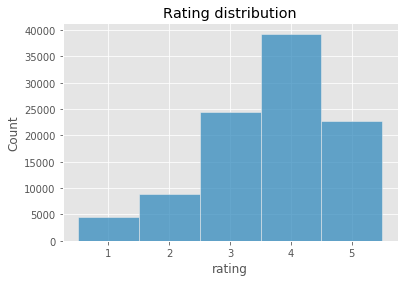

In [18]:

average_rating=movie_rating['rating'].mean()
print(f'average_rating={(average_rating)}')
sns.histplot(data=movie_rating, x="rating", binwidth=1)
plt.title('Rating distribution')

### In the figure above we can see a gaussian like distribution around the rating 4, with average rating of 3.5.
### it seems to be a good idea to normalize the rating per user, 
### so it will be more efective to compare between users preferences 
### so to delete " bias" ratings of users. 




### Lets observe the mean rating of the users.



In [26]:
users_average_rate

,userId,avg_rating
0,1,2.550000
1,2,3.486842
2,3,3.568627
3,4,4.348039
4,5,3.910000
...,...,...
666,667,3.647059
667,668,3.750000
668,669,3.351351
669,670,3.806452


Text(0.5, 1.0, 'Average Rating per user')

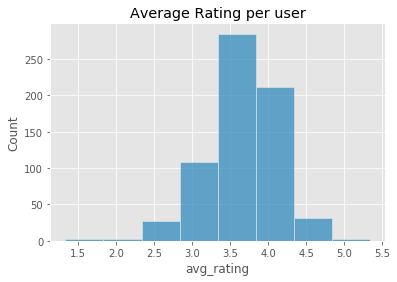

In [28]:

sns.histplot(data=users_average_rate, x="avg_rating", binwidth=0.5)
plt.title('Average Rating per user')

### From the histogram above, we can see that usersr have diffrent tenency to rate moves. 

## The next step will be to see the histogram of how many movies were rated by each user:

min rated number -20, max rated number - 2391 


Text(0.5, 1.0, 'Distrubuation of how many movies were rated by each user')

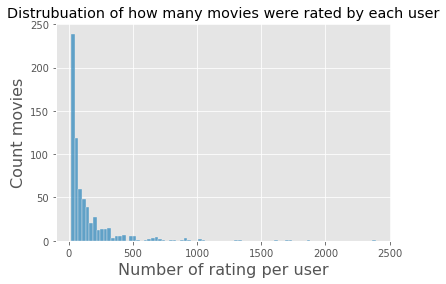

In [19]:
users_count_rated_movies=movie_rating.groupby(by=['userId']).count()
max_num_rated=users_count_rated_movies['movieId'].max()
min_num_rated=users_count_rated_movies['movieId'].min()
print(f'min rated number -{min_num_rated}, max rated number - {max_num_rated} ')

# we have users who only 20 and users who rated up to 2391 movies
# lets look at the distrbution

users_count_rated_movies=users_count_rated_movies.reset_index()
sns.histplot(users_count_rated_movies["movieId"], kde=False);
plt.xlabel('Number of rating per user', fontsize=16)
plt.ylabel('Count movies', fontsize=16)
plt.title('Distrubuation of how many movies were rated by each user')

Text(0.5, 1.0, 'Distrubuation of how many movies were rated by each user')

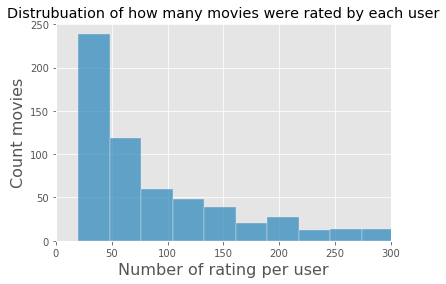

In [21]:
# lets get a close look 
sns.histplot(users_count_rated_movies["movieId"], kde=False);
plt.xlim(0,300)
plt.xlabel('Number of rating per user', fontsize=16)

plt.ylabel('Count movies', fontsize=16)
plt.title('Distrubuation of how many movies were rated by each user')

#### We can see  we have users who are rate with higher rate.




## Histogram of how many users, watch a specific movie:

In [16]:
total=users_count_rated_movies.shape[0]
at_least_50=100*(users_count_rated_movies[users_count_rated_movies["movieId"]<51].shape[0]/total)
at_least_100=100*(users_count_rated_movies[users_count_rated_movies["movieId"]<100].shape[0]/total)
at_least_150=100*(users_count_rated_movies[users_count_rated_movies["movieId"]<150].shape[0]/total)
median=users_count_rated_movies['movieId'].median()
print(f' precentage at least 50- {round(at_least_50)}%,  precentage at least 150- {round(at_least_150)}%, median {median}')

 precentage at least 50- 37%,  precentage at least 150- 73%, median 71.0


#### Most users - 73 %, have rated al least 150 diffrent movies.  The median is 71.

Text(0.5, 1.0, 'number of rating per movie')

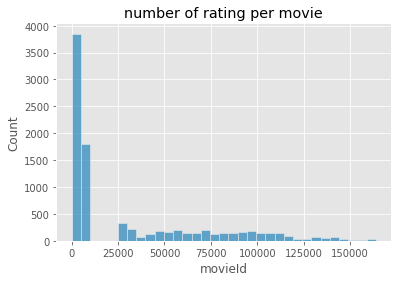

In [19]:
users_per_movie=movie_rating.groupby(by=['movieId']).count().reset_index() # how many users watch a movie
sns.histplot(users_per_movie["movieId"], kde=False);
plt.title('number of rating per movie')

In [20]:
median=users_per_movie['userId'].median()
print('median=',median)

median= 3.0



#### Most movies has ~ 3 users who watched them, most users rated at least  70 movies. The average rating is 3.5 and it see that the rating distributin is gaussian around 4. From this we can duduce that the data is suitable for user bsed algorithm. to conclude, .this suggest that a user - item base algorithm will work better then item item based

In [23]:
# what is the bias: 



average_rating=3.543608255669773


# Model Training 

In [24]:
import random
import ipynb.fs.full.utilteies as ut # this file -utilteies -  includes some function that i build to help with the model building.

from surprise import Reader
from surprise import Dataset
from surprise import KNNBaseline

from surprise.model_selection import cross_validate
from surprise import SVD
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

reader = Reader(rating_scale=(1, 5))


In [25]:
data = Dataset.load_from_df(movie_rating[['userId', 'movieId', 
                                    'rating']], reader)

raw_ratings = data.raw_ratings
# shuffle ratings if you want
random.shuffle(raw_ratings)
threshold1 = int(.60 * len(raw_ratings))
threshold2=int(.80 * len(raw_ratings))
train_data = raw_ratings[:threshold1]
chosing_algo_test_data = raw_ratings[threshold1:threshold2]
final_test_data= raw_ratings[threshold2:]
# test_data=
data.raw_ratings = train_data  # data is now the set A
# data_for_opti=data
# data_for_opti.raw_ratings=raw_ratings[:threshold2]
# A = 75% of the data, B = 25% of the data


In [26]:
# chooosing the best algorithm

In [27]:
from surprise import KNNBaseline
sim_options = {'name': 'pearson', 'user_based': True }
pear = KNNBaseline(sim_options=sim_options)

sim_options = {'name': 'cosine', 'user_based': True}
cos = KNNBaseline(sim_options=sim_options)

svd=SVD()
trainset = data.build_full_trainset()
score_dic={'RMSE':'n','F1_score':'n'}
total_score={}
for algo_name, algo in {'PEAR':pear,'COS':cos,'SVD':svd }.items():
    algo.fit(trainset)
    
    # Compute unbiased accuracy 
    chosing_algo = data.construct_testset(chosing_algo_test_data)  # testset is now the set B
    predictions = algo.test(chosing_algo)
    rmse=accuracy.rmse(predictions)
    temp=score_dic.copy()
    temp['RMSE']=rmse
    precisions, recalls,f1_score = ut.precision_recall_at_k(predictions, k=10, threshold=3.5)
    temp['F1_score']=f1_score
    total_score[algo_name]=temp

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9171
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9081
RMSE: 0.8977


In [28]:
pd.DataFrame.from_dict(total_score)

,PEAR,COS,SVD
RMSE,0.917143,0.908089,0.897667
F1_score,0.367766,0.364351,0.356837


It seems that both for F1 score and RMSE score, the svd algorithm 
is the best choice.

next step is to optimize the SVD algorithm

# Optimazation of the SVD algorithm

In [29]:
# param_grid = {'n_epochs': [ 20, 30], 
#         'lr_all': [.005, .001, .01, 0.1],'reg_all': [0.2, 0.3]}
# gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=4)
# gs.fit(data)



In [30]:
param_grid = {'n_epochs': [  30], 
        'lr_all': [ .01],'reg_all': [0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=4)
gs.fit(data)
# check if there is convergence, do a graph 


In [31]:
print(gs.best_params['rmse'])
print(gs.best_score['rmse'])
algo=gs.best_estimator['rmse']


{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}
0.9022255022824448


In [32]:
# {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}
# 0.9041219469929693


# Final testing of model accuracy

In [33]:
# choosing the best parameters 
algo=gs.best_estimator['rmse']
# retrain on the whole set A
trainset = data.build_full_trainset()
algo.fit(trainset)
test = data.construct_testset(final_test_data)  # testset is now the set B
predictions = algo.test(test)
print('Unbiased accuracy ', end=' ')
accuracy.rmse(predictions)
print('Unbiased f1 score ', end=' ')
precisions, recalls,f1_score = ut.precision_recall_at_k(predictions, k=10, threshold=3.5)
print(f1_score)

Unbiased accuracy  RMSE: 0.9055
Unbiased f1 score  0.3569103826418687


In [77]:
precisions, recalls

(0.7284523809523803, 0.6997653541304614)

In [ ]:
# Ella notes 
# how do u ases the model 
# think about proxy, how can i say according to the data, see if the recomandation was good. 
# how to define the loss function (read about it ). 
# false positve rate from the proxy ! 

### Training on the entire data set

In [34]:
data = Dataset.load_from_df(movie_rating[['userId', 'movieId', 
                                    'rating']], reader)
trainset = data.build_full_trainset()
algo.fit(trainset)


In [35]:
final_test = data.construct_testset(raw_ratings)
prediction=algo.test(final_test)
accuracy.rmse(predictions)
precisions, recalls,f1_score = ut.precision_recall_at_k(predictions, k=10, threshold=3.5)
print(f1_score)

RMSE: 0.9055
0.3569103826418687


In [36]:
k=10
precisions, recalls,f1_score = ut.precision_recall_at_k(predictions, k, threshold=3.5)
print(f'pre={precisions}, recall={recalls}, f1_score={f1_score},')

pre=0.7284523809523803, recall=0.6997653541304614, f1_score=0.3569103826418687,


### Building recomandations 

In [37]:
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

In [38]:
top_n_df = ut.get_top_n(predictions, n=10)
top_n_df

,UserID,movieID and rating
0,1,"[(5114, 3.5775190294397836), (73290, 3.5744935..."
1,2,"[(116, 4.380429445562818), (1939, 4.3689797148..."
2,3,"[(5114, 4.30555551860428), (116, 4.28703400252..."
3,4,"[(116, 5), (5114, 4.9705344187910905), (73290,..."
4,5,"[(5114, 4.7094011896427395), (116, 4.664805226..."
...,...,...
666,667,"[(5114, 4.461414882248078), (116, 4.4220179484..."
667,668,"[(3038, 4.394740971411224), (5475, 4.379645851..."
668,669,"[(116, 4.3443308044145255), (116897, 4.3289421..."
669,670,"[(5114, 4.510425448375302), (7116, 4.479535484..."


In [39]:
top_n_df.loc[0,'movieID and rating']

[(5114, 3.5775190294397836),
 (73290, 3.5744935907835718),
 (2924, 3.5411192029519163),
 (1939, 3.524348359997334),
 (116, 3.50715087420844),
 (1948, 3.5029992510345287),
 (8132, 3.5024685831450575),
 (116897, 3.4948379402512844),
 (26729, 3.4888035559176203),
 (3310, 3.4853115023878094)]

In [40]:
top_n_df.to_csv('recomadation_user.csv')

# Results analysis 
Does check the results makes sense?

lets look on only one the recondation estimation: 

In [41]:
movie_rating

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0
...,...,...,...
99999,671,6268,2.5
100000,671,6269,4.0
100001,671,6365,4.0
100002,671,6385,2.5


In [42]:
movie_rating.sort_values(by='movieId')


,userId,movieId,rating
9713,68,1,4.0
35933,261,1,1.5
52631,383,1,5.0
35983,262,1,2.5
12038,77,1,4.0
...,...,...,...
39546,287,161944,5.0
11823,73,162376,4.5
92339,611,162542,5.0
92340,611,162672,3.0


In [43]:
movie_rating['movieId'].unique().shape

(9066,)

In [44]:
top_n_df = ut.get_top_n(predictions, n=1)
top_n_df.to_csv('recomadation_user_only_one.csv')
top_n_df

,UserID,movieID and rating
0,1,"[(5114, 3.5775190294397836)]"
1,2,"[(116, 4.380429445562818)]"
2,3,"[(5114, 4.30555551860428)]"
3,4,"[(116, 5)]"
4,5,"[(5114, 4.7094011896427395)]"
...,...,...
666,667,"[(5114, 4.461414882248078)]"
667,668,"[(3038, 4.394740971411224)]"
668,669,"[(116, 4.3443308044145255)]"
669,670,"[(5114, 4.510425448375302)]"


In [45]:
# now lets move to a more coftamble way of dealing with the data 

In [46]:
top_n_df = ut.get_top_n(predictions, n=1)
top_n_df['movieID and rating']=pd.DataFrame(top_n_df['movieID and rating'].tolist())
top_n_df[['movieID','estRating']]=pd.DataFrame(top_n_df['movieID and rating'].tolist())
top_n_df

,UserID,movieID and rating,movieID,estRating
0,1,"(5114, 3.5775190294397836)",5114,3.577519
1,2,"(116, 4.380429445562818)",116,4.380429
2,3,"(5114, 4.30555551860428)",5114,4.305556
3,4,"(116, 5)",116,5.000000
4,5,"(5114, 4.7094011896427395)",5114,4.709401
...,...,...,...,...
666,667,"(5114, 4.461414882248078)",5114,4.461415
667,668,"(3038, 4.394740971411224)",3038,4.394741
668,669,"(116, 4.3443308044145255)",116,4.344331
669,670,"(5114, 4.510425448375302)",5114,4.510425


In [47]:
# lets find out which are the recomanded movies: 
# we saw that there are 18 unique values ! 

In [78]:
top_18_model=list(top_n_df['movieID'].unique())


KeyError: 'movieID'

In [49]:
# now lets see if this data makes sense. 
# we might expect that the best rated movies will be in that list
movies=movie_rating.groupby(['movieId'])
best_movies_by_rating=movie_rating.groupby(['movieId']).mean().reset_index().sort_values('rating',ascending=False)
top_18=best_movies_by_rating.head(18)
top_18_best=list(top_18['movieId'])


In [53]:
# it seems that this is not the case. might be due to the fact that
# those movies were not rated by enough users

# so we might expect that the most rated by users movies will be on the list

In [54]:
# lets look on the movies that was rated by most users  
most_movies_by_users=movie_rating.groupby(['movieId']).count().reset_index().sort_values('rating',ascending=False)
top_18_users=most_movies_by_users.head(18)
top_18_users=list(top_18_users['movieId'])


In [55]:
list(set(top_18_model).intersection(top_18_users))

[318]

In [56]:
# we see that one does appear. 

# lest have another look on the top 18 from the model 

In [57]:
top_18_df_model=movie_rating[movie_rating['movieId'].isin(top_18_model)]
top_18_df_model

,userId,movieId,rating
4,1,1172,4.0
101,3,318,5.0
180,4,858,5.0
370,5,858,2.5
511,7,318,5.0
...,...,...,...
98783,664,858,4.0
99297,665,318,5.0
99802,668,318,4.0
99867,670,318,5.0


No handles with labels found to put in legend.


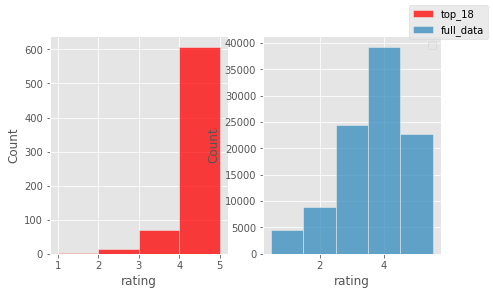

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(7, 4))


# rating distribution 
sns.histplot(data=top_18_df_model, x="rating", binwidth=1, ax=axs[0],color='red')
# plt.title('Rating distribution, top 18')
plt.legend()

# hist=users_average_rate['avg_rating'].hist()
sns.histplot(data=movie_rating, x="rating", binwidth=1, ax=axs[1])
# plt.title('Rating distribution full data')
fig.legend(labels=['top_18','full_data'])
plt.show()

In [59]:
# we can see that in contrast the the all data behavior, the top 18 rating distrubtion is high
# this makes sense, we would expect the most reconaded to be popular in general
top_18_df_model.groupby(by=['userId']).count()

,movieId,rating
userId,,
1,1,1
3,1,1
4,1,1
5,1,1
7,1,1
...,...,...
664,2,2
665,1,1
668,1,1


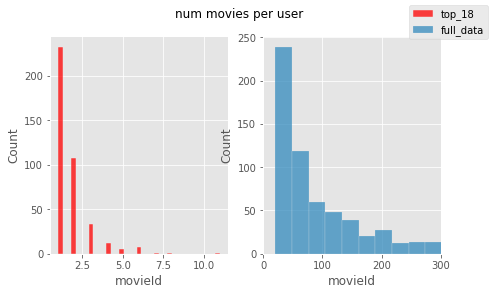

In [60]:
users_count_rated_movies=movie_rating.groupby(by=['userId']).count()
users_count_rated_movies_top_18=top_18_df_model.groupby(by=['userId']).count()

# we have users who only 20 and users who rated up to 2391 movies
# lets look at the distrbution

users_count_rated_movies=users_count_rated_movies.reset_index()
users_count_rated_movies_top_18=users_count_rated_movies_top_18.reset_index()


fig, axs = plt.subplots(1, 2, figsize=(7, 4))

# rating distribution 
sns.histplot(users_count_rated_movies_top_18["movieId"], ax=axs[0],color='red')
ax1=axs[0]
sns.histplot(users_count_rated_movies["movieId"], ax=axs[1])
ax2=axs[1]
ax2.set_xlim((0,300))
fig.suptitle('num movies per user')
fig.legend(labels=['top_18','full_data'])
plt.show()



In [61]:
# the top 18 distrubution seems quite similar to the distrubution of all data. 

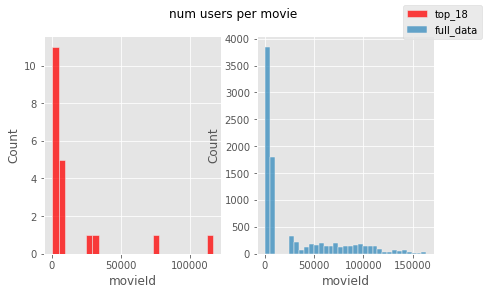

In [62]:
# now lets look on how many users rated a movie:
fig, axs = plt.subplots(1, 2, figsize=(7, 4))
users_per_movie=movie_rating.groupby(by=['movieId']).count().reset_index() # how many users watch a movie
users_per_movie_top_18=top_18_df_model.groupby(by=['movieId']).count().reset_index() # how many users watch a movie

sns.histplot(users_per_movie_top_18['movieId'], ax=axs[0],color='red')
# ax1=axs[0]
sns.histplot(users_per_movie['movieId'], ax=axs[1])
# ax2=axs[1]
# ax2.set_xlim((0,300))
fig.suptitle('num users per movie')
fig.legend(labels=['top_18','full_data'])
plt.show()


In [63]:
# we can see the top 18 distrubtion is more concetrated around relativly large amount of users who have rated the movie. This leas to similarties between users
# this is something we would expect ! 

# Item similarty
## use case :
suppose that our user is looking on a specif movie on the web,
we would like to recomand him only the movies that are related 
to the movie on the web. meaning we would exclude the non related items from the recomandation list that was based on user similarties. 

In [64]:
movie_rating['movieId'].max()

163949

In [65]:
data = Dataset.load_from_df(movie_rating[['userId', 'movieId', 
                                    'rating']], reader)
raw_ratings = data.raw_ratings
# shuffle ratings if you want
random.shuffle(raw_ratings)
threshold = int(.75 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]
trainset = data.build_full_trainset()


In [66]:
from surprise import get_dataset_dir


In [67]:
from surprise import KNNBaseline
sim_options = {'name': 'cosine', 'user_based': False}
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [68]:
# I choose cosine similarty over pearson since we saw that it was better. 

In [69]:
# now give the user 100 (id) is viewing the movie :6000(id)
# lets get the 10 nearest neighbors 

In [70]:
# loading the recomandation list 
top_n_df=pd.read_csv('recomadation_user.csv',index_col='UserID')
top_n_df

,Unnamed: 0,movieID and rating
UserID,,
1,0,"[(5114, 3.5775190294397836), (73290, 3.5744935..."
2,1,"[(116, 4.380429445562818), (1939, 4.3689797148..."
3,2,"[(5114, 4.30555551860428), (116, 4.28703400252..."
4,3,"[(116, 5), (5114, 4.9705344187910905), (73290,..."
5,4,"[(5114, 4.7094011896427395), (116, 4.664805226..."
...,...,...
667,666,"[(5114, 4.461414882248078), (116, 4.4220179484..."
668,667,"[(3038, 4.394740971411224), (5475, 4.379645851..."
669,668,"[(116, 4.3443308044145255), (116897, 4.3289421..."


In [71]:
from ast import literal_eval
def get_user_movie_list(df,userID):
    list_rate_movies_user=list(df.loc[userID,'movieID and rating'])
    rec_movis_u=[i[0] for i in list_rate_movies_user]
    return  rec_movis_u

In [72]:
def top_related_movies(df,userID, movie_raw_id,n=5):
    rec_movis_u=get_user_movie_list(df,userID)
    movie_inner_id=trainset.to_inner_iid(movie_raw_id)
    neighbors=[]
    k=n
    l=0
    while l<n:
        movie_neighbors = algo.get_neighbors(movie_inner_id, k)
        movie_neighbors_raw_id=[trainset.to_raw_iid(i) for i in movie_neighbors]
        l=len(list(set(movie_neighbors_raw_id).intersection(rec_movis_u)))
        k=2*k
    neighbors=list(set(movie_neighbors_raw_id).intersection(rec_movis_u))[:n]
    return neighbors

In [73]:
# loading the recomandation list 
top_n_df=pd.read_csv('recomadation_user.csv',index_col='UserID')
top_n_df['movieID and rating']= top_n_df['movieID and rating'].apply(lambda x: literal_eval(str(x)))
top_n_df



,Unnamed: 0,movieID and rating
UserID,,
1,0,"[(5114, 3.5775190294397836), (73290, 3.5744935..."
2,1,"[(116, 4.380429445562818), (1939, 4.3689797148..."
3,2,"[(5114, 4.30555551860428), (116, 4.28703400252..."
4,3,"[(116, 5), (5114, 4.9705344187910905), (73290,..."
5,4,"[(5114, 4.7094011896427395), (116, 4.664805226..."
...,...,...
667,666,"[(5114, 4.461414882248078), (116, 4.4220179484..."
668,667,"[(3038, 4.394740971411224), (5475, 4.379645851..."
669,668,"[(116, 4.3443308044145255), (116897, 4.3289421..."


In [75]:
top_related_movies(top_n_df,userID=100, movie_raw_id=500,n=5)


[8132, 73290, 7116, 2924, 1939]

This is the 5 most related movies from the user - user recomandation list ! 


In [ ]:
# check wether there is diffrent. item based. read about it. 
# check with proxy. 